## Results of parameters line search for the GF dataset with a single replicate. 

### Data preprocessing and augmentation

Total length of trajectories is 240.

Validation set was also randomly cropped, so slightly different at every epoch!

    data_train = myDataset(dataset=data.train_set, transform=transforms.Compose([
        RandomCrop(output_size=length, ignore_na_tails=True),
        transforms.RandomApply([RandomNoise(mu=0, sigma=0.02)]),
        Subtract([data.stats['mu']['AKT']['train']]),
        ToTensor()
    ]))
    data_test = myDataset(dataset=data.validation_set, transform=transforms.Compose([
        RandomCrop(output_size=length, ignore_na_tails=True),
        Subtract([data.stats['mu']['AKT']['train']]),
        ToTensor()
    ]))

### Loss and optimizer

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 400, 600, 800], gamma=0.5)


### The default parameters

    params = {'nepochs': 1000,
              'batch_size':128,
              'length': 200,
              'nclass': 7,
              'nfeatures':20,
              'lr': 1e-2}



### The models

One model for both univariate, one model for bivariate.


class ConvNetCam(nn.Module):

    def __init__(self, batch_size, nclass=7, nfeatures=20, length=120):
        super(ConvNetCam, self).__init__()

        self.batch_size = batch_size
        self.nclass = nclass
        self.nfeatures = nfeatures
        self.length = length

        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(20),
            nn.ReLU(True),
            nn.Conv1d(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(20),
            nn.ReLU(True),
            nn.Conv1d(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(20),
            nn.ReLU(True),
            nn.Conv1d(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(20),
            nn.ReLU(True),
            nn.Conv1d(in_channels=20, out_channels=20, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(20),
            nn.ReLU(True),
            nn.Conv1d(in_channels=20, out_channels=nfeatures, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(nfeatures),
            nn.ReLU(True)
        )
        self.pool = nn.AvgPool1d(kernel_size=self.length)
        self.classifier = nn.Sequential(
            nn.Linear(1*nfeatures, nclass),  # 1 because global pooling reduce length of features to 1
            #nn.Softmax(1)  # Already included in nn.CrossEntropy
        )

    def forward(self, x):
        # (batch_size x length TS)
        x = self.features(x)

        # (batch_size x nfeatures x length_TS)
        # Average pooling for CAM: global pooling so set kernel size to all data
        x = self.pool(x)

        # (batch_size x nfeatures x length_pool; length_pool=1 if global pooling)
        # Flatten features (size batch, lengthpool * nchannels)
        x = x.view(self.batch_size, x.size(2)*self.nfeatures)
        x = self.classifier(x)
        return x


class ConvNetCamBi(nn.Module):
    # Consider the bivariate series as a 2D image
    def __init__(self, batch_size, nclass=7, nfeatures=20, length=120):
        super(ConvNetCamBi, self).__init__()

        self.batch_size = batch_size
        self.nclass = nclass
        self.nfeatures = nfeatures
        self.length = length

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(3,5), stride=1, padding=(1,2)),
            nn.BatchNorm2d(20),
            nn.ReLU(True),
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3,5), stride=1, padding=(1,2)),
            nn.BatchNorm2d(20),
            nn.ReLU(True),
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3,5), stride=1, padding=(1,2)),
            nn.BatchNorm2d(20),
            nn.ReLU(True),
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3,5), stride=1, padding=(1,2)),
            nn.BatchNorm2d(20),
            nn.ReLU(True),
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3,3), stride=1, padding=(1,1)),
            nn.BatchNorm2d(20),
            nn.ReLU(True),
            nn.Conv2d(in_channels=20, out_channels=nfeatures, kernel_size=(3,3), stride=1, padding=(1,1)),
            nn.BatchNorm2d(nfeatures),
            nn.ReLU(True)
        )
        self.pool = nn.AvgPool2d(kernel_size=(2, self.length))
        self.classifier = nn.Sequential(
            nn.Linear(1*nfeatures, nclass),  # 1 because global pooling reduce length of features to 1
            #nn.Softmax(1)  # Already included in nn.CrossEntropy
        )

    def forward(self, x):
        # (batch_size x number_pixel_row x length_TS)
        x = self.features(x)

        # (batch_size x nfeatures x number_pixel_row x length_TS)
        # Average pooling for CAM: global pooling so set kernel size to all data
        x = self.pool(x)

        # (batch_size x nfeatures x length_pool; length_pool=1 if global)
        # Flatten features (batch_size, length_pool * nchannels)
        x = x.view(self.batch_size, x.size(2)*self.nfeatures)
        x = self.classifier(x)
        return x



## Results 

Logs from tensorboard were exported on the server where the models were trained and tuned into csv.

Results are smoothed with a rolling average over 20 epochs.

### ERK model


In [5]:
import pandas as pd
from ggplot import *

df = pd.read_csv('../output/result_linesearch/ERK.csv')
df = df.melt(['linesearch_var', 'linesearch_val', 'step'])
df['color_var'] = df['linesearch_var'] + '_' + df['linesearch_val'].map(str)
df['smooth_value'] = df.groupby(['linesearch_var','linesearch_val', 'variable'])['value'].apply(lambda x:x.rolling(window=20, center=False).mean())                                                                                                       

#### Length


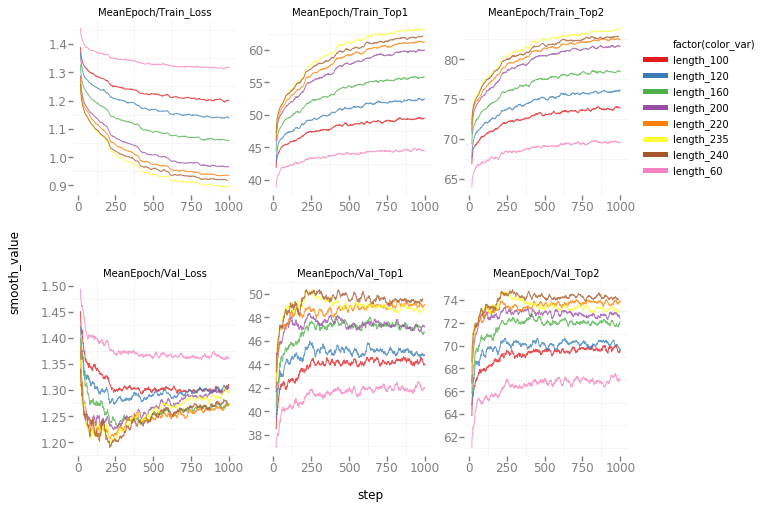

<ggplot: (-9223363291101709245)>

In [6]:
ggplot(df[df['linesearch_var']=='length'], aes(x='step', y='smooth_value', color='factor(color_var)')) +\
    geom_line(aes(group='linesearch_val'), alpha=0.75) +\
    facet_wrap('variable', scales='free_y', ncol=3) +\
    theme_bw() +\
    scale_color_brewer(type='qual', palette='Set1')


#### Number of features in layer before softmax

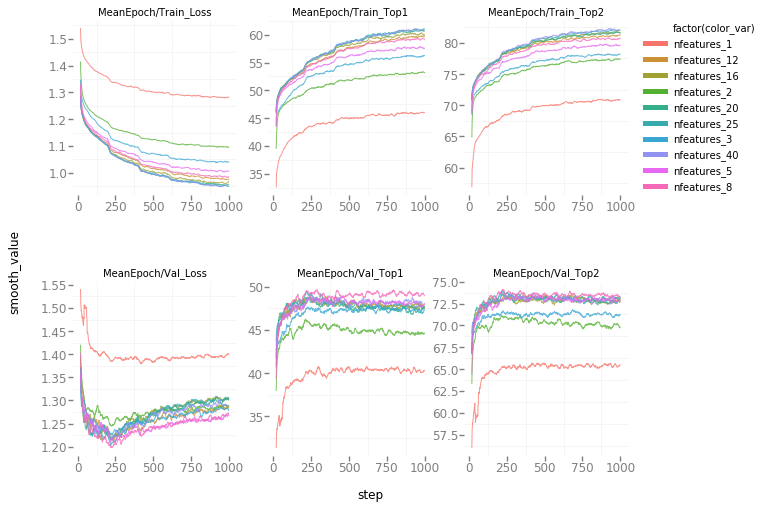

<ggplot: (-9223363291099138069)>

In [7]:
ggplot(df[df['linesearch_var']=='nfeatures'], aes(x='step', y='smooth_value', color='factor(color_var)')) +\
    geom_line(aes(group='linesearch_val'), alpha=0.75) +\
    facet_wrap('variable', scales='free_y', ncol=3) +\
    theme_bw() #+\
    #scale_color_brewer(type='qual', palette='Set1')


#### Batch size

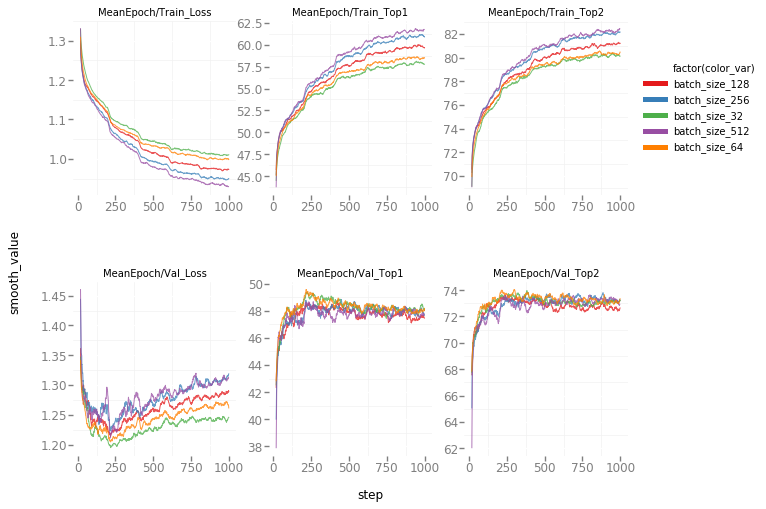

<ggplot: (8745756406704)>

In [8]:
ggplot(df[df['linesearch_var']=='batch_size'], aes(x='step', y='smooth_value', color='factor(color_var)')) +\
    geom_line(aes(group='linesearch_val'), alpha=0.75) +\
    facet_wrap('variable', scales='free_y', ncol=3) +\
    theme_bw() +\
    scale_color_brewer(type='qual', palette='Set1')




### AKT model


In [9]:
import pandas as pd
from ggplot import *

df = pd.read_csv('../output/result_linesearch/AKT.csv')
df = df.melt(['linesearch_var', 'linesearch_val', 'step'])
df['color_var'] = df['linesearch_var'] + '_' + df['linesearch_val'].map(str)
df['smooth_value'] = df.groupby(['linesearch_var','linesearch_val', 'variable'])['value'].apply(lambda x:x.rolling(window=20, center=False).mean())                                                                                                       


#### Length

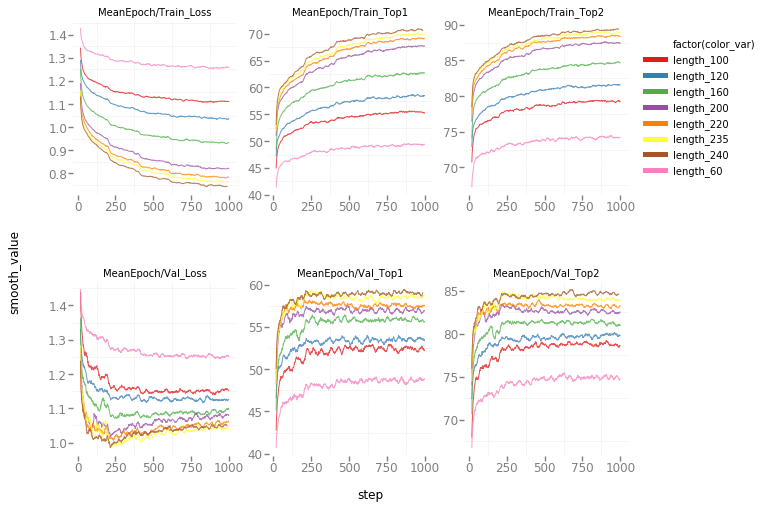

<ggplot: (-9223363291099148309)>

In [10]:
ggplot(df[df['linesearch_var']=='length'], aes(x='step', y='smooth_value', color='factor(color_var)')) +\
    geom_line(aes(group='linesearch_val'), alpha=0.75) +\
    facet_wrap('variable', scales='free_y', ncol=3) +\
    theme_bw() +\
    scale_color_brewer(type='qual', palette='Set1')


#### Number of features in layer before softmax

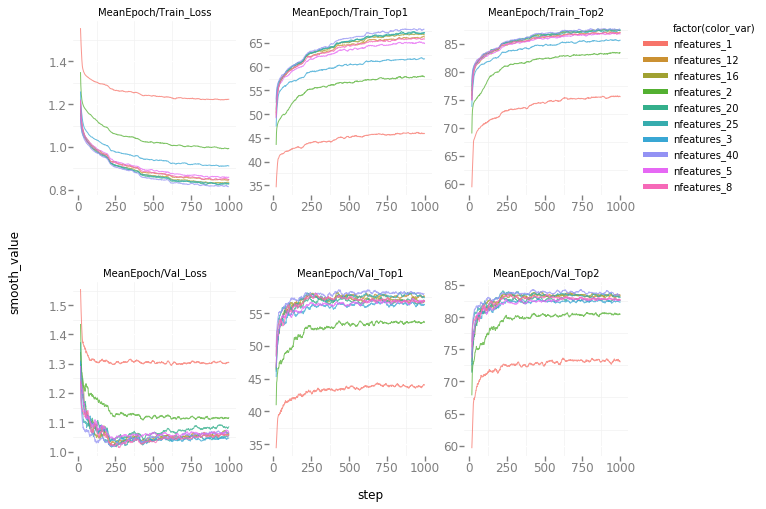

<ggplot: (8745755439578)>

In [11]:
ggplot(df[df['linesearch_var']=='nfeatures'], aes(x='step', y='smooth_value', color='factor(color_var)')) +\
    geom_line(aes(group='linesearch_val'), alpha=0.75) +\
    facet_wrap('variable', scales='free_y', ncol=3) +\
    theme_bw() #+\
    #scale_color_brewer(type='qual', palette='Set1')


#### Batch size

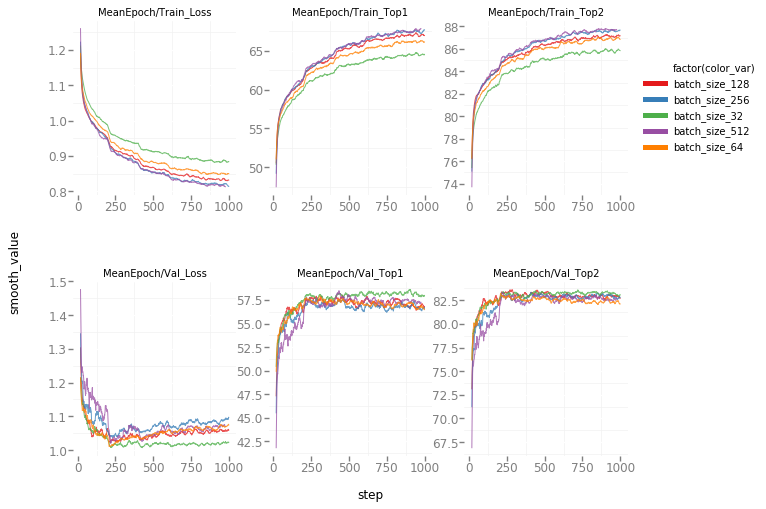

<ggplot: (8745738786603)>

In [12]:
ggplot(df[df['linesearch_var']=='batch_size'], aes(x='step', y='smooth_value', color='factor(color_var)')) +\
    geom_line(aes(group='linesearch_val'), alpha=0.75) +\
    facet_wrap('variable', scales='free_y', ncol=3) +\
    theme_bw() +\
    scale_color_brewer(type='qual', palette='Set1')



### ERK_AKT model


In [13]:
import pandas as pd
from ggplot import *

df = pd.read_csv('../output/result_linesearch/ERK_AKT.csv')
df = df.melt(['linesearch_var', 'linesearch_val', 'step'])
df['color_var'] = df['linesearch_var'] + '_' + df['linesearch_val'].map(str)
df['smooth_value'] = df.groupby(['linesearch_var','linesearch_val', 'variable'])['value'].apply(lambda x:x.rolling(window=20, center=False).mean())                                                                                                       


#### Length

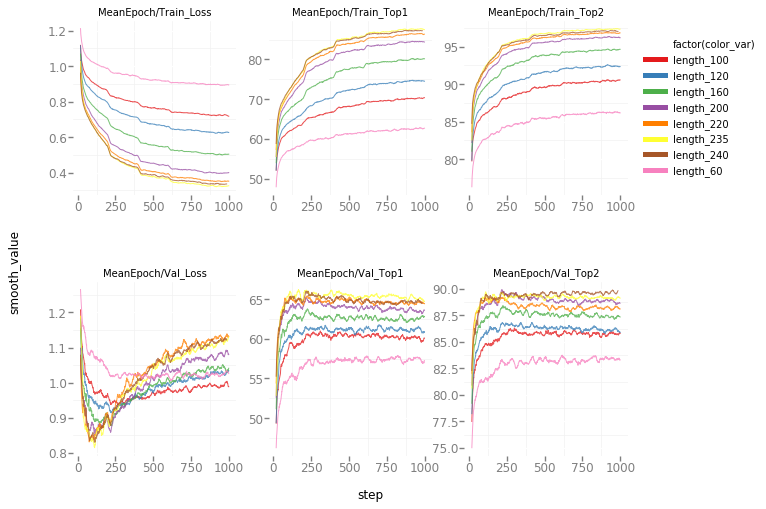

<ggplot: (8745756021473)>

In [14]:
ggplot(df[df['linesearch_var']=='length'], aes(x='step', y='smooth_value', color='factor(color_var)')) +\
    geom_line(aes(group='linesearch_val'), alpha=0.75) +\
    facet_wrap('variable', scales='free_y', ncol=3) +\
    theme_bw() +\
    scale_color_brewer(type='qual', palette='Set1')


#### Number of features in layer before softmax

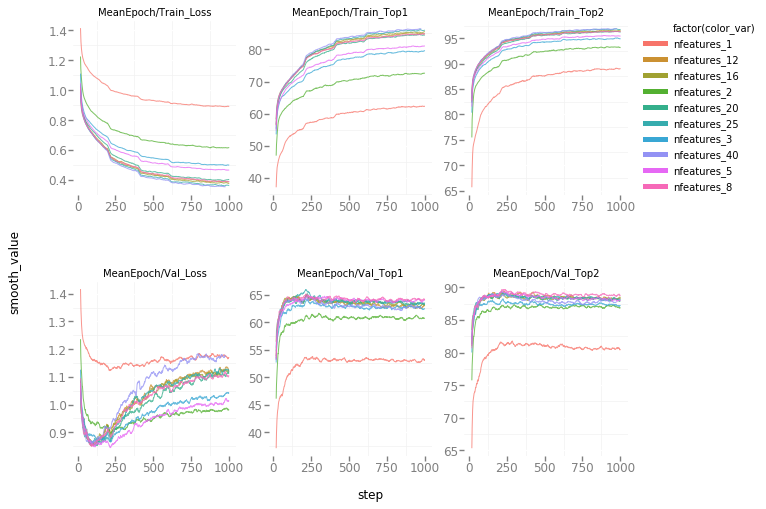

<ggplot: (-9223363291117170074)>

In [15]:
ggplot(df[df['linesearch_var']=='nfeatures'], aes(x='step', y='smooth_value', color='factor(color_var)')) +\
    geom_line(aes(group='linesearch_val'), alpha=0.75) +\
    facet_wrap('variable', scales='free_y', ncol=3) +\
    theme_bw() #+\
    #scale_color_brewer(type='qual', palette='Set1')


#### Batch size

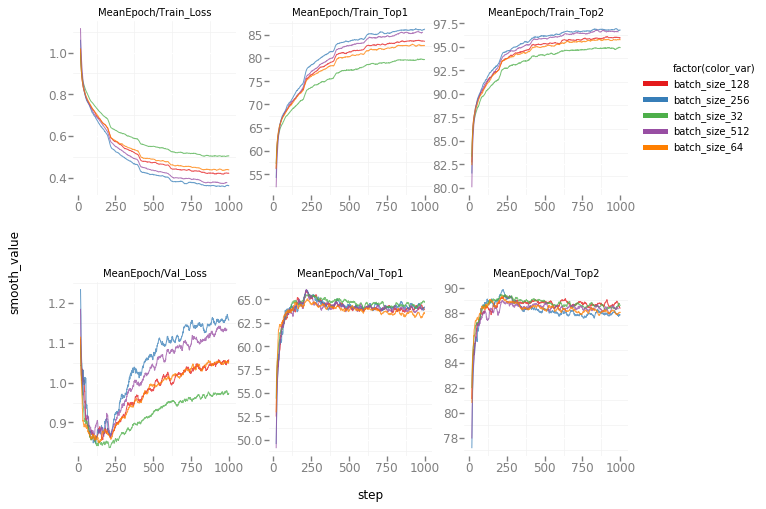

<ggplot: (8745754824740)>

In [16]:
ggplot(df[df['linesearch_var']=='batch_size'], aes(x='step', y='smooth_value', color='factor(color_var)')) +\
    geom_line(aes(group='linesearch_val'), alpha=0.75) +\
    facet_wrap('variable', scales='free_y', ncol=3) +\
    theme_bw() +\
    scale_color_brewer(type='qual', palette='Set1')